## Motivation and Baseline Analysis

In the previous notebook, we established a **baseline** using **Logistic Regression**. 

### Why did we start with Logistic Regression?
1.  **Interpretability:** It provides a clear understanding of feature importance (which words predict which class).
2.  **Efficiency:** It trains very fast on sparse high-dimensional data (like TF-IDF vectors).
3.  **Baseline:** It tests the hypothesis that the data is *linearly separable*.

### Analysis of Baseline Results
Our Logistic Regression model achieved:
* **Accuracy:** ~60%
* **F1-Macro:** ~0.56

**Critical Observation:**
Looking at the classification report, we see a significant disparity between classes:
* **Class 2 (F1 = 0.78):** The model identifies this class very well.
* **Class 0 (F1 = 0.39) & Class 1 (F1 = 0.46):** The model struggles significantly here. 

This suggests that the relationship between our text features and these specific categories might be **non-linear** or too complex for a simple linear boundary to capture. 

### Next Steps: Expanding the Model Space
To improve upon this baseline, specifically for the underperforming classes (0 and 1), we will now train and compare multiple algorithm families:

1.  **Support Vector Machines (LinearSVC):** often superior in high-dimensional text spaces.
2.  **Multinomial Naive Bayes:** A probabilistic approach that handles text count data well.
3.  **Random Forest:** An ensemble method that can capture **non-linear** relationships and complex feature interactions.
4.  **SGD Classifier:** A flexible linear classifier optimized with Stochastic Gradient Descent.

We will keep the **preprocessing (TF-IDF)** and **balancing (RandomOverSampler)** strategies constant to ensure a fair comparison.

## 1. Load Preprocessed Data
(Same as `model_training` notebook)

In [1]:
import pandas as pd
import numpy as np
from scipy import sparse

X_train = sparse.load_npz("train_features.npz")
X_test = sparse.load_npz("test_features.npz")
y_train = pd.read_csv("code-comment-classification-train-target.csv").values.ravel() 
y_test = pd.read_csv("code-comment-classification-test-target.csv").values.ravel()

## 2. Define Multiple Models with Balancing
We define a dictionary of models. Each model is wrapped in an `ImbPipeline` containing the `RandomOverSampler`. This ensures fair comparison.

In [2]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

# Dictionary of pipelines
models = {
    "Logistic Regression": ImbPipeline([
        ('oversample', RandomOverSampler(random_state=42)),
        ('clf', LogisticRegression(max_iter=1000))
    ]),
    
    "SGD Classifier": ImbPipeline([
        ('oversample', RandomOverSampler(random_state=42)),
        ('clf', SGDClassifier(loss='hinge', random_state=42))
    ]),
    
    "Linear SVC": ImbPipeline([
        ('oversample', RandomOverSampler(random_state=42)),
        ('clf', LinearSVC(random_state=42, dual='auto'))
    ]),
    
    "Multinomial NB": ImbPipeline([
        ('oversample', RandomOverSampler(random_state=42)),
        ('clf', MultinomialNB())
    ]),
    
    "Random Forest": ImbPipeline([
        ('oversample', RandomOverSampler(random_state=42)),
        ('clf', RandomForestClassifier(n_estimators=100, random_state=42))
    ])
}

print(f"Defined {len(models)} models with balancing strategies.")

Defined 5 models with balancing strategies.


## 3. Train and Compare Models
We loop through the models, performing Cross-Validation on the training set. We track `F1-Macro` because it is the most important metric for our imbalanced data.

In [3]:
from sklearn.model_selection import cross_val_score

results = []

print("Starting Model Evaluation...")

for name, pipeline in models.items():
    print(f"Training {name}...")
    
    # Cross-Validation (Balancing happens automatically inside folds)
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='f1_macro')
    
    results.append({
        "Model": name,
        "Mean F1-Macro": cv_scores.mean(),
        "Std Dev": cv_scores.std()
    })

# Create DataFrame of results
results_df = pd.DataFrame(results).sort_values(by="Mean F1-Macro", ascending=False)
print("\n=== MODEL COMPARISON RESULTS ===")
print(results_df)

Starting Model Evaluation...
Training Logistic Regression...
Training SGD Classifier...
Training Linear SVC...
Training Multinomial NB...
Training Random Forest...

=== MODEL COMPARISON RESULTS ===
                 Model  Mean F1-Macro   Std Dev
0  Logistic Regression       0.575579  0.027703
2           Linear SVC       0.569674  0.014322
1       SGD Classifier       0.566158  0.007410
3       Multinomial NB       0.556354  0.028057
4        Random Forest       0.537993  0.014881


## 4. Visual Comparison of Model Performance
We visualize the **Mean F1-Macro scores** to identify the best model.
- We use `plt.barh` because we are plotting **summary statistics** (already calculated means) rather than raw data.
- The black lines (`xerr`) represent the **Standard Deviation**. A short line means the model is stable; a long line means the performance varies a lot between different data splits.

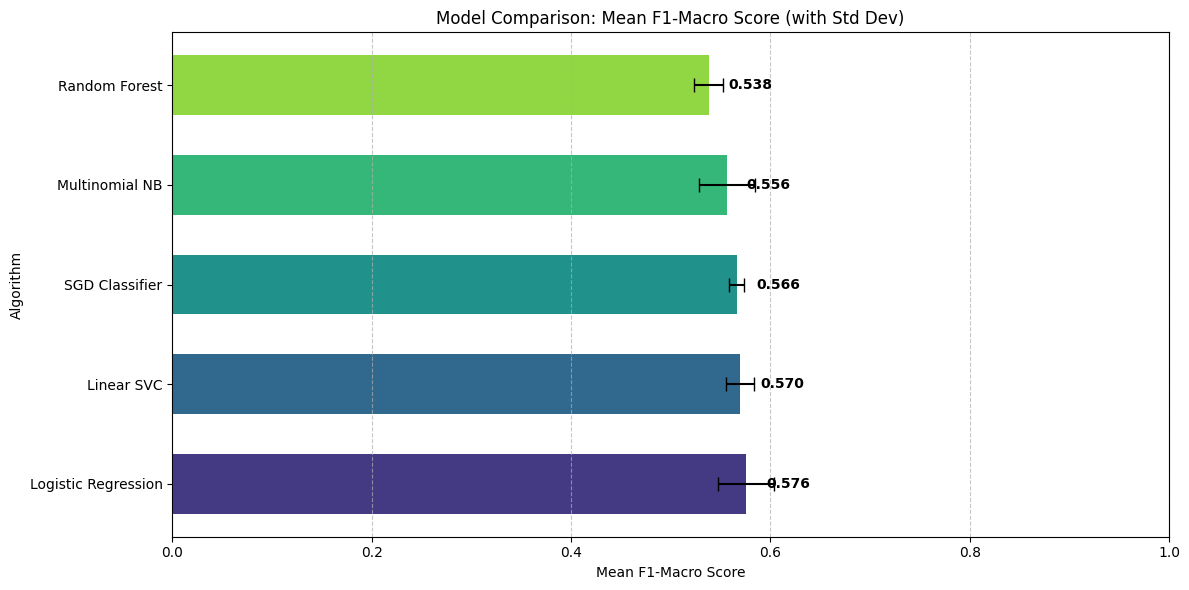

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))

# 1. Create a color palette
colors = sns.color_palette("viridis", len(results_df))

# 2. Plot Horizontal Bars
# We use 'barh' because it handles pre-calculated error bars (xerr) correctly
bars = plt.barh(
    y=results_df["Model"], 
    width=results_df["Mean F1-Macro"], 
    xerr=results_df["Std Dev"], 
    color=colors, 
    capsize=5,  # Adds the little cross-bar at the end of the error line
    height=0.6
)

plt.title("Model Comparison: Mean F1-Macro Score (with Std Dev)")
plt.xlabel("Mean F1-Macro Score")
plt.ylabel("Algorithm")
plt.xlim(0, 1.0) # F1 score is always between 0 and 1

# 3. Add numerical labels to the bars
for bar in bars:
    width = bar.get_width()
    plt.text(
        width + 0.02,                      # x-position (slightly to the right of the bar)
        bar.get_y() + bar.get_height()/2,  # y-position (centered)
        f"{width:.3f}", 
        va='center', 
        fontweight='bold'
    )

plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## 5. Final Evaluation on Locked Test Set
Cross-validation helped us select the winner. Now we must perform the **final test** on the held-out data (`test.csv`) that the model has never seen before.
1. **Select Winner:** We automatically pick the model at the top of our `results_df`.
2. **Retrain:** We fit this model on the entire training set to maximize learning.
3. **Predict:** We evaluate it on the locked Test Set.

  The Winning Model is: Logistic Regression
   (Mean CV F1-Score: 0.5756)

Retraining the best model on the full training dataset...
Retraining complete.

=== FINAL TEST SET PERFORMANCE ===
Accuracy: 0.5969

Classification Report:

              precision    recall  f1-score   support

           0       0.35      0.45      0.39        62
           1       0.46      0.46      0.46       101
           2       0.79      0.77      0.78       159
           3       0.57      0.54      0.55        91
           4       0.63      0.61      0.62       160

    accuracy                           0.60       573
   macro avg       0.56      0.56      0.56       573
weighted avg       0.61      0.60      0.60       573



<Figure size 1000x800 with 0 Axes>

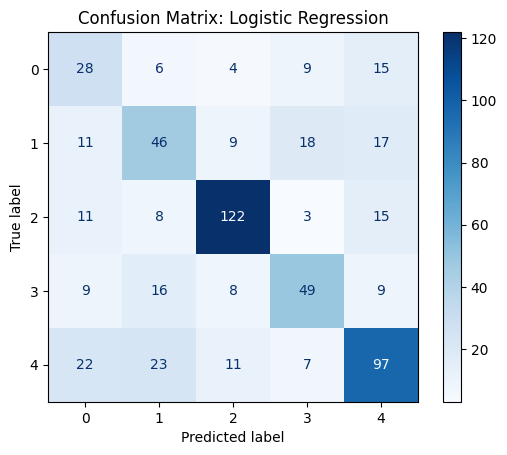

In [5]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report

# 1. Identify the Best Model automatically
best_model_name = results_df.iloc[0]["Model"]
best_pipeline = models[best_model_name]

print(f"  The Winning Model is: {best_model_name}")
print(f"   (Mean CV F1-Score: {results_df.iloc[0]['Mean F1-Macro']:.4f})")

# 2. Retrain on the full training set
print("\nRetraining the best model on the full training dataset...")
best_pipeline.fit(X_train, y_train)
print("Retraining complete.")

# 3. Final Prediction on the Locked Test Set
y_pred_final = best_pipeline.predict(X_test)

# 4. Report Results
print("\n=== FINAL TEST SET PERFORMANCE ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_final):.4f}")
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_final))

# 5. Visualize Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred_final)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')
plt.title(f"Confusion Matrix: {best_model_name}")
plt.show()

## 6. Save the Best Model
Finally, we serialize (save) the entire pipeline. This file includes the preprocessing steps (if any were added to the pipeline), the balancing strategy, and the trained classifier weights.

In [6]:
import joblib

# Define a filename
filename = "best_model_final.pkl"

# Save the pipeline object
joblib.dump(best_pipeline, filename)

print(f"Model successfully saved to: {filename}")
print("You can load this model later using: model = joblib.load('best_model_final.pkl')")

Model successfully saved to: best_model_final.pkl
You can load this model later using: model = joblib.load('best_model_final.pkl')


## 7. Conclusions and Future Work

### Analysis of Results
Our experiments concluded that **Logistic Regression** is the best performing model for this dataset, achieving a **Macro F1-Score of 0.57** on the test set.

**Key Observations:**
1.  **Class 2 is Solved:** The model achieves an F1-score of **0.78** for Class 2, indicating that the vocabulary for this category is distinct and well-separated.
2.  **Struggle with Classes 0 & 1:**
    * **Class 0 (F1=0.39):** The model has low precision (0.35), meaning it frequently "hallucinates" this class when it shouldn't.
    * **Class 1 (F1=0.46):** Performance is mediocre, suggesting semantic overlap with other categories.
3.  **Impact of Balancing:** While Random Oversampling ensured that minority classes were not ignored (recall is decent), it did not solve the underlying issue of **semantic ambiguity**.

### Why did sophisticated models fail?
Complex models like Random Forest often require more data to find non-linear patterns. With a small dataset (~2000 rows), a simple linear model (Logistic Regression) often generalizes better, as seen here.

### Next Steps (Future Improvements)
To break the 60% accuracy ceiling, we need to move beyond simple word counting (TF-IDF):

1.  **Deep Learning (BERT/Transformers):**
    * Instead of counting words, use a pre-trained language model like **BERT** or **CodeBERT**. These models understand *context* (e.g., the difference between "running a function" and "running out of time").
    
2.  **Advanced Data Augmentation:**
    * Instead of simple duplication (Oversampling), use **Paraphrasing** (using an LLM to rewrite comments) to create semantically diverse training examples.

3.  **Ensemble Learning:**
    * Combine the predictions of Logistic Regression and SVM (Voting Classifier) to see if their combined wisdom improves stability.